In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *

/home/caitsithx/anaconda2/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)
Using Theano backend.


In [14]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [4]:
path = "data/dvc_small/"
model_path = path + "models/"
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [6]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

In [7]:
vld_batches = get_batches(path+"valid", shuffle=False, batch_size=1)
trn_batches = get_batches(path+"train", shuffle=False, batch_size=1)

Found 2000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [8]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [9]:
#vld_data = get_data(path+"valid")
#trn_data = get_data(path+"valid")
vld_data = load_array(model_path+"valid_data.bc")
trn_data = load_array(model_path+"train_data.bc")

In [13]:
vld_data.shape

(2000, 3, 224, 224)

In [15]:
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [18]:
vld_batches.classes[:2]

array([0, 0], dtype=int32)

In [19]:
vld_labels = onehot(vld_batches.classes)
trn_labels = onehot(trn_batches.classes)

In [20]:
vld_labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [21]:
vld_batches.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [22]:
vld_features = model.predict(vld_data, batch_size=100)
trn_features = model.predict(trn_data, batch_size=100)

In [23]:
#save_array(model_path+ 'train_lastlayer_features.bc', trn_features)
#save_array(model_path + 'valid_lastlayer_features.bc', vld_features)

NameError: name 'val_features' is not defined

In [24]:
linear_model = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])

In [26]:
linear_model.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
linear_model.fit(trn_features, trn_labels, nb_epoch=3, batch_size=100, 
       validation_data=(vld_features, vld_labels))

Train on 10000 samples, validate on 2000 samples
Epoch 1/3
10000/10000 [==============================] - 0s - loss: 0.0652 - acc: 0.9772 - val_loss: 0.0603 - val_acc: 0.9770
Epoch 2/3
10000/10000 [==============================] - 0s - loss: 0.0627 - acc: 0.9781 - val_loss: 0.0568 - val_acc: 0.9805
Epoch 3/3
10000/10000 [==============================] - 0s - loss: 0.0609 - acc: 0.9786 - val_loss: 0.0546 - val_acc: 0.9790

In [29]:
linear_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_7 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


In [30]:
??Sequential

In [33]:
preds = linear_model.predict_classes(vld_features, batch_size=100)

 100/2000 [>.............................] - ETA: 0s

In [34]:
preds[:8]

array([0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
pros = linear_model.predict_proba(vld_features, batch_size=100)

 100/2000 [>.............................] - ETA: 0s

In [37]:
cat_probs = pros[:,0]

In [41]:
filenames = vld_batches.filenames;

In [52]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path+"valid/"+filenames[i]) for i in idx], titles=titles)

In [49]:
correct = np.where(preds==vld_labels[:,1])[0]
n_view=4

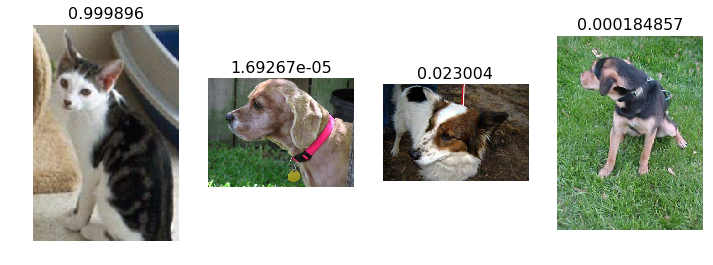

In [57]:
idx = permutation(correct)[:n_view]
plots_idx(idx, cat_probs[idx])

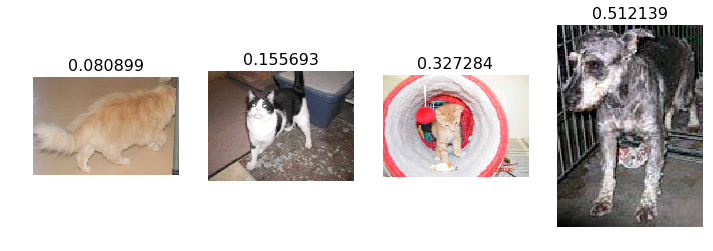

In [59]:
incorrect = np.where(preds!=vld_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, cat_probs[idx])